In [ ]:
import os
import sys
sys.path.append('../')
from utils import visualize_images
from diffusers import StableDiffusionPipeline
from semantic_aug.augmentations.textual_inversion import load_embeddings
device = 'cuda:1'
os.environ["DISABLE_TELEMETRY"] = 'YES'
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",local_files_only = True).to(device)

## Using the montage to showcase the generated samples of different fine-tuning strategies.

In [ ]:
from PIL import Image
import os
from utils import DATASET_NAME_MAPPING
import random
def create_image_grid(input_dir, output_path):
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(image_files)
    while len(image_files) < 8:
        image_files.append(None)

    grid_image = Image.new('RGB', (224*8, 224*1), (255, 255, 255))

    for i in range(8):
        row = i // 8
        col = i % 8

        if image_files[i] is not None:
            image_path = os.path.join(input_dir, image_files[i])
            img = Image.open(image_path)
            img = img.resize((224, 224), Image.ANTIALIAS)
            grid_image.paste(img, (col * 224, row * 224))
        else:
            grid_image.paste(Image.new('RGB', (224, 224), (255, 255, 255)), (col * 224, row * 224))

    grid_image.save(output_path)
    
def create_image_grid_for_ds(dataset_name, class_name, output_path):
    ds = DATASET_NAME_MAPPING[dataset_name]()
    target_indices=ds.label_to_indices[ds.class2label[class_name.replace('_', ' ')]]

    while len(target_indices) < 8:
        target_indices.append(None)

    grid_image = Image.new('RGB', (224*8, 224*1), (255, 255, 255))

    for i in range(8):
        row = i // 8
        col = i % 8

        if target_indices[i] is not None:
            img = ds.get_image_by_idx(target_indices[i])
            img = img.resize((224, 224), Image.ANTIALIAS)
            grid_image.paste(img, (col * 224, row * 224))
        else:
            grid_image.paste(Image.new('RGB', (224, 224), (255, 255, 255)), (col * 224, row * 224))

    grid_image.save(output_path)

In [ ]:
dataset_name='cub'
dirname = 'American_Three_toed_Woodpecker'
output_path = f'../figures/case_real_{dirname}.pdf'
create_image_grid_for_ds(dataset_name,dirname, output_path)

input_directory = f'../outputs/aug_samples/cub/real-generation-Multi5/data/{dirname}'
output_path = f'../figures/case_realgen_{dirname}.pdf'
create_image_grid(input_directory, output_path)
for strategy in ['db','ti','ti_db']:
    input_directory = f'../outputs/aug_samples/cub/dreambooth-lora-generation-Multi1_{strategy}_latest/data/{dirname}'
    output_path = f'../figures/case_{strategy}_{dirname}.pdf'
    create_image_grid(input_directory, output_path)

## Instance visualization

In [ ]:
import random
from utils import DATASET_NAME_MAPPING, AUGMENT_METHODS, parse_finetuned_ckpt


def synthesize_images(model, strength, train_dataset,source_label=1, target_label=2, seed=0, source_image=None):
    random.seed(seed)
    target_indice = random.sample(train_dataset.label_to_indices[target_label], 1)[0]

    if source_image is None:
        source_indice = random.sample(train_dataset.label_to_indices[source_label], 1)[0]
        source_image = train_dataset.get_image_by_idx(source_indice)
    target_metadata = train_dataset.get_metadata_by_idx(target_indice)
    image, _ = model(image=[source_image], label=target_label, strength=strength, metadata=target_metadata)
    return image
# 初始化训练数据集
def get_train_dataset(dataset_name):
    return DATASET_NAME_MAPPING[dataset_name](split="train")




# 初始化模型
def initialize_model(augmentation_name, embed_path, lora_path, prompt, guidance_scale, device):
    AUGMENT_METHODS[augmentation_name].pipe = None
    model = AUGMENT_METHODS[augmentation_name](
        embed_path=embed_path,
        lora_path=lora_path,
        prompt=prompt,
        guidance_scale=guidance_scale,
        mask=False,
        inverted=False,
        device=device
    )
    return model


# 定义渐进式翻译函数
def progressive_translation(model, strength_list, train_dataset, source_label, target_label,source_image=None, output_dir='../examples/progressive_translation/'):
    os.makedirs(output_dir, exist_ok=True)
    image_list = []

    for strength in strength_list:
        image = synthesize_images(
            model=model,
            strength=strength,
            train_dataset=train_dataset,
            source_label=source_label,
            target_label=target_label,
            source_image=source_image
        )
        image_list.append(image[0])

    visualize_images(
        images=image_list,
        nrow=len(image_list),
        show=False,
        save=True,
        outpath=os.path.join(output_dir, f'{target_label}-{source_label}.png')
    )



In [ ]:
DATASET_NAME = 'cub'  # 可选 'cub', 'aircraft'
AUGMENTATION_NAME = 'dreambooth-lora-mixup'  
FINETUNED_MODEL_KEY = 'db_ti_latest'
GUIDANCE_SCALE = 7
PROMPT_TEMPLATE = "a photo of a {name}"
gpu_id = 7
seed = 6

train_dataset = get_train_dataset(DATASET_NAME)
lora_path, embed_path = parse_finetuned_ckpt(DATASET_NAME, FINETUNED_MODEL_KEY)
model = initialize_model(AUGMENTATION_NAME, embed_path, lora_path, PROMPT_TEMPLATE, GUIDANCE_SCALE, f'cuda:{gpu_id}')



In [ ]:
from itertools import product
SOURCE_LABEL_LIST = list(range(20))
TARGET_LABEL_LIST = list(range(20))
STRENGTH_LIST = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
for source_label, target_label in product(SOURCE_LABEL_LIST, TARGET_LABEL_LIST):
    progressive_translation(model, STRENGTH_LIST, train_dataset, source_label, target_label)

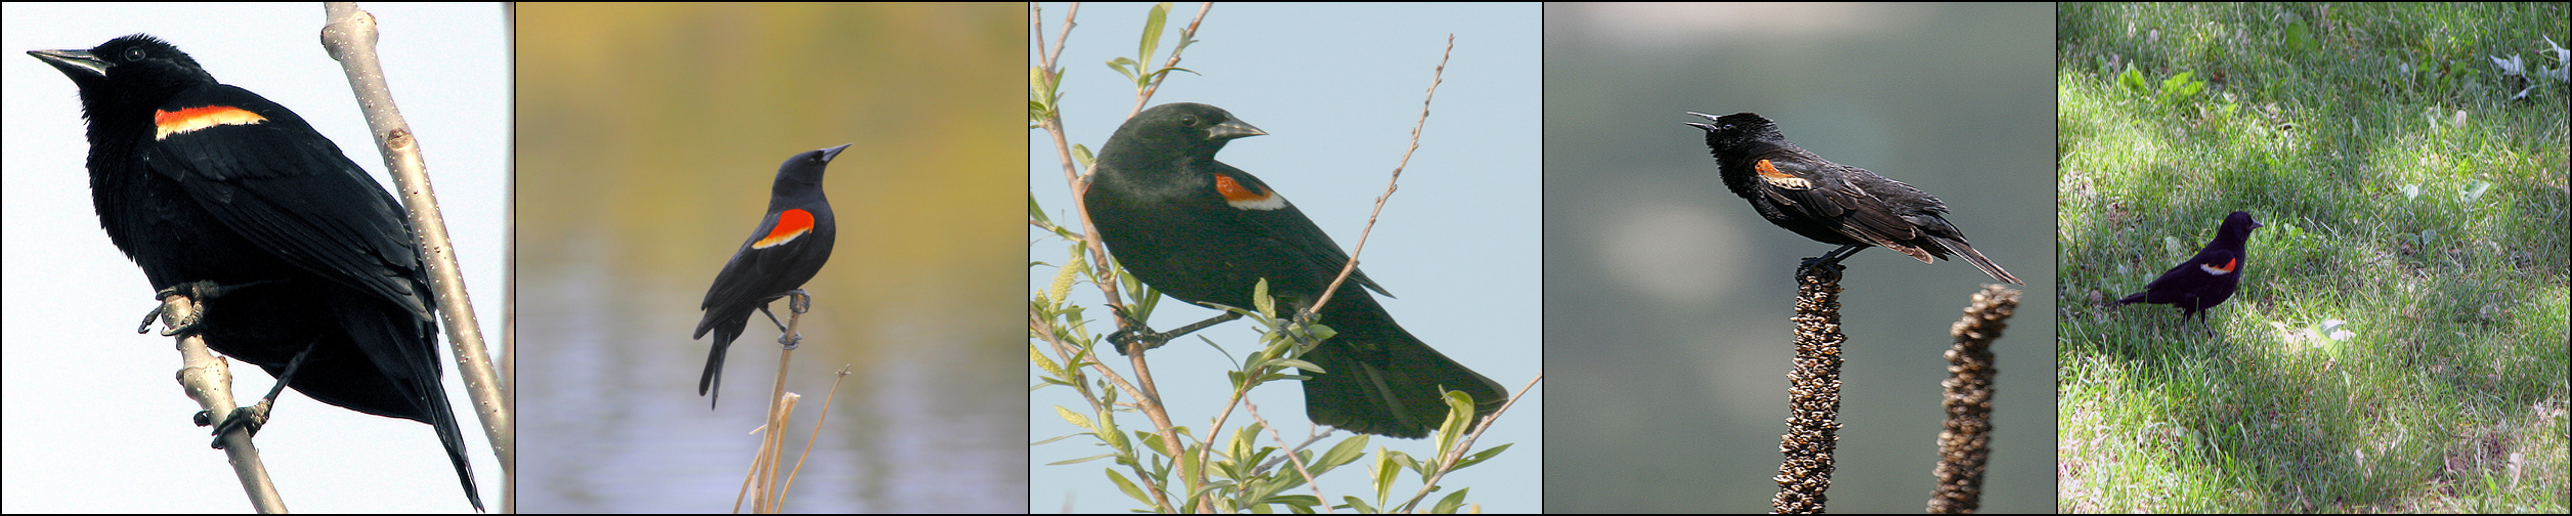

In [45]:
seed = 16
random.seed(seed)
source_label=9
target_label=9
source_indices = random.sample(train_dataset.label_to_indices[source_label], 5)
target_indice = random.sample(train_dataset.label_to_indices[target_label], 1)[0]

source_image_list = [train_dataset.get_image_by_idx(source_indice).resize((512,512)) for source_indice in source_indices]
visualize_images(source_image_list,nrow=5,show=False,save=False,outpath='outputs/debug/real_images.png')

In [46]:
source_indices

[281, 285, 279, 283, 277]

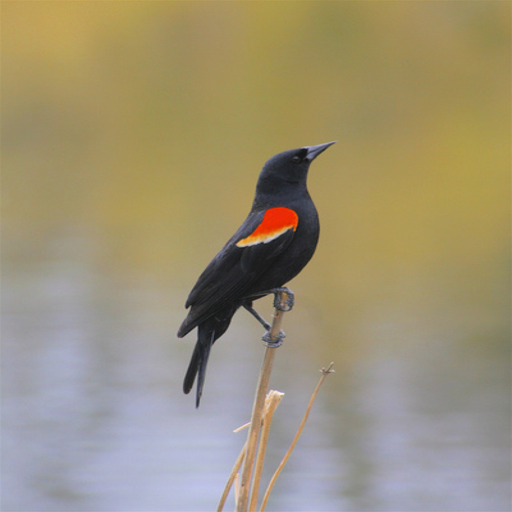

In [47]:
source_image = train_dataset.get_image_by_idx(285).resize((512,512))
source_image

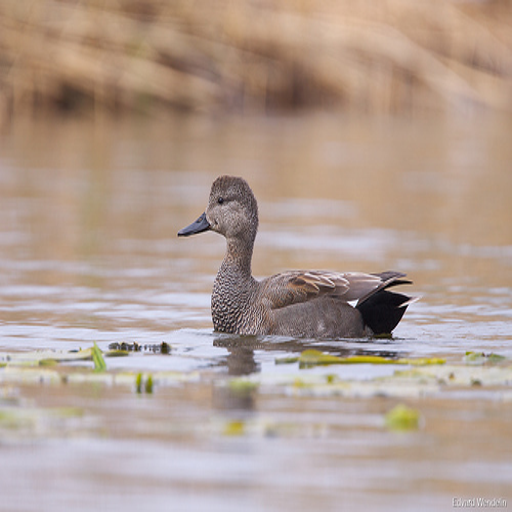

In [44]:
source_image

a photo of a <class_9> bird


a photo of a <class_9> bird


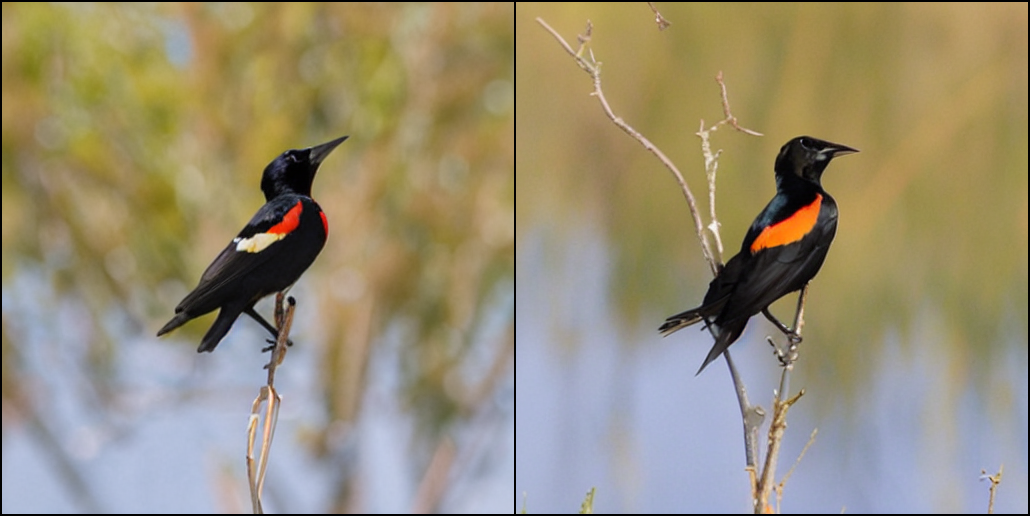

In [51]:
strength_list = [0.7] * 2
target_label=9
image_list = []
for strength in strength_list:
    image = synthesize_images(
        model=model,
        strength=strength,
        train_dataset=train_dataset,
        source_label=source_label,
        target_label=target_label,
        source_image=source_image
    )
    image_list.append(image[0])

visualize_images(
    images=image_list,
    nrow=len(image_list),
    show=False,
    save=False,
    outpath=None)
